In [20]:
# coding:utf-8
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
import keras.backend as K

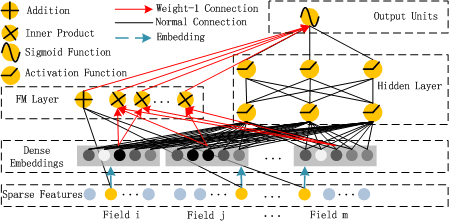

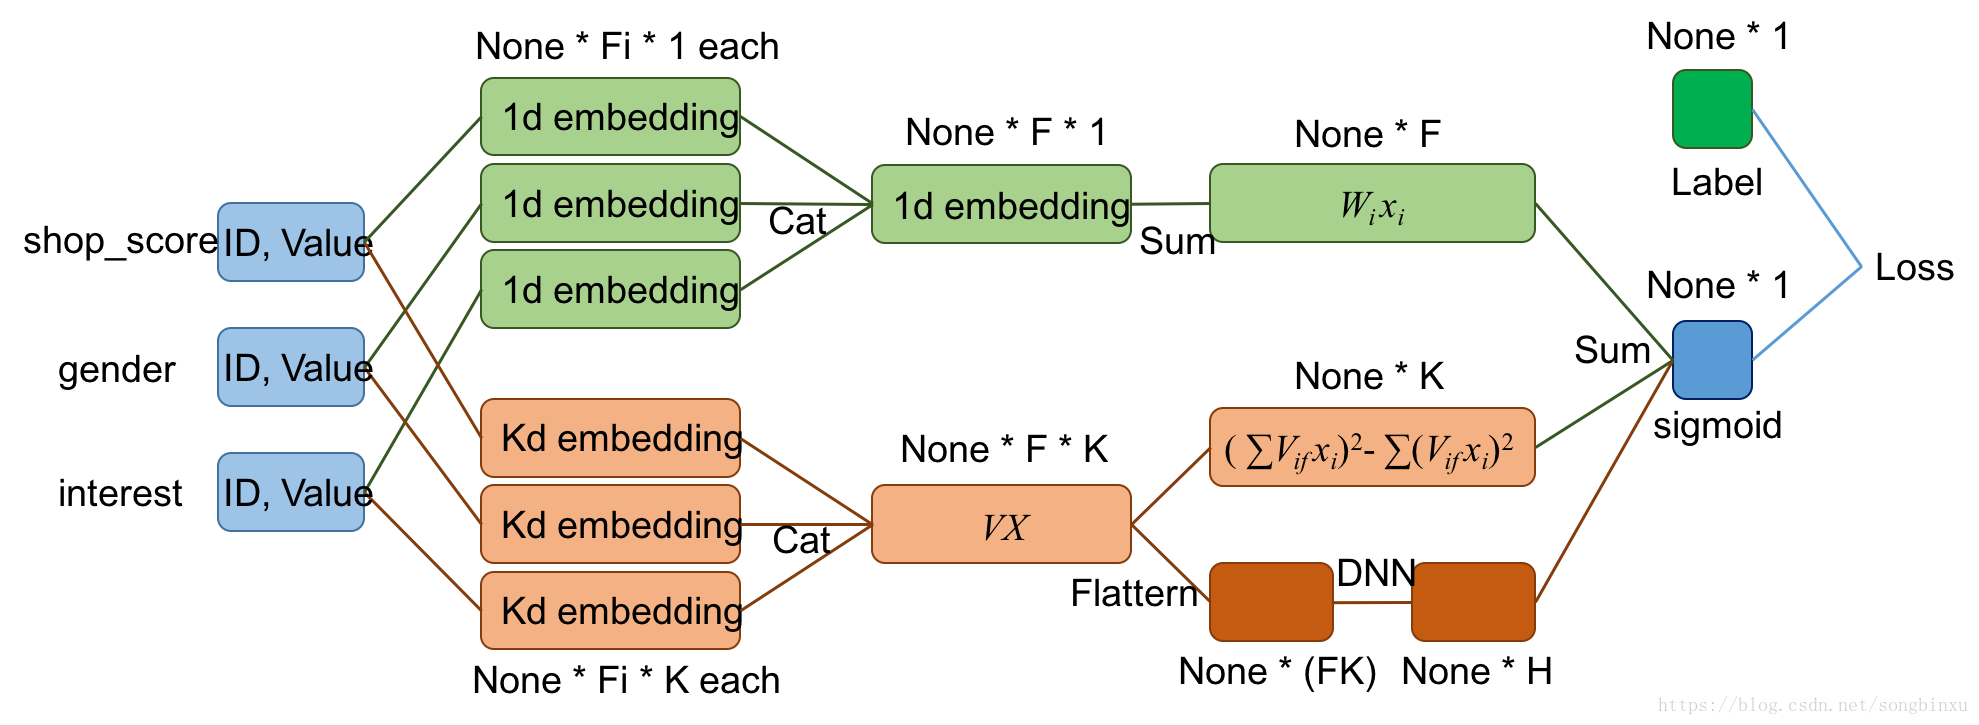

In [21]:
# numeric fields
in_score = Input(shape=[1], name="score") # None*1
in_sales = Input(shape=[1], name="sales") # None*1
# single value categorical fields
in_gender = Input(shape=[1], name="gender") # None*1
in_age = Input(shape=[1], name="age") # None*1
# multiple value categorical fields
in_interest = Input(shape=[3], name="interest") # None*3, 最长长度3
in_topic = Input(shape=[4], name="topic") # None*4, 最长长度4

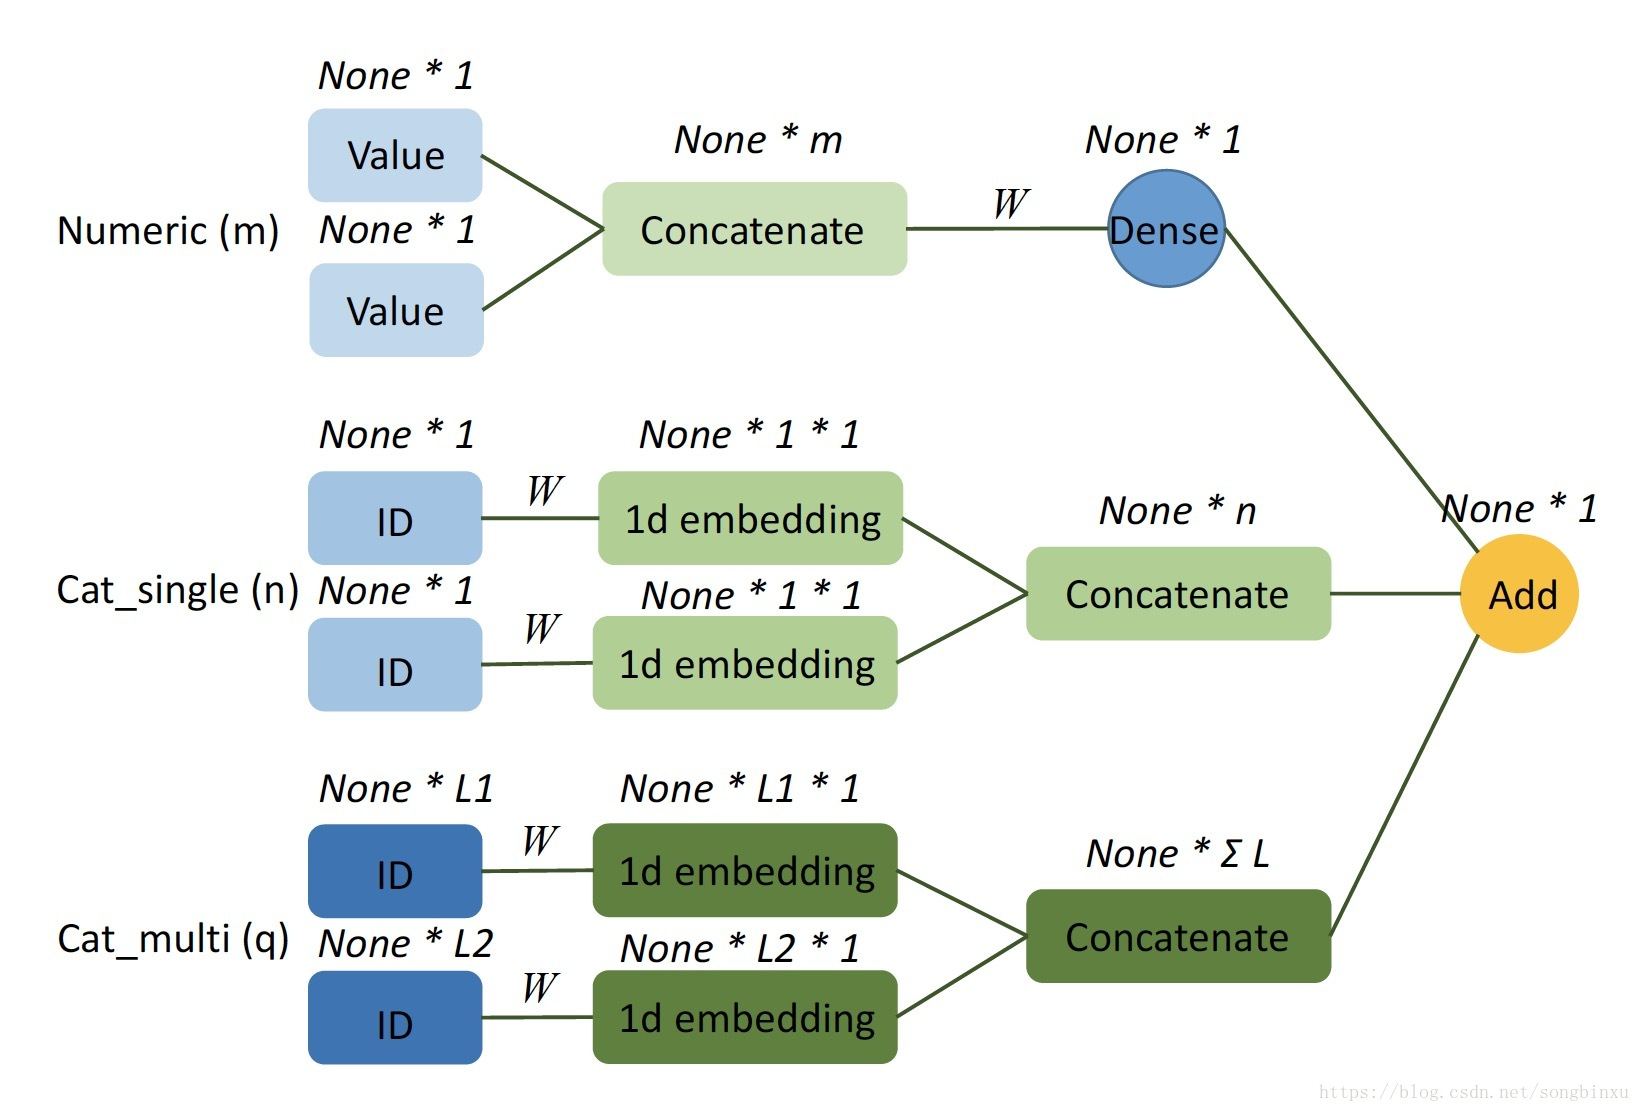

In [22]:
Embedding(3, 2)(in_gender)

<tf.Tensor 'embedding_15/GatherV2:0' shape=(?, 1, 2) dtype=float32>

In [23]:
# First Order Embeddings
numeric = Concatenate()([in_score, in_sales]) # None*2
dense_numeric = Dense(1)(numeric) # None*1
emb_gender_1d = Reshape([1])(Embedding(3, 1)(in_gender)) # None*1
emb_age_1d = Reshape([1])(Embedding(10, 1)(in_age)) # None*1
emb_interest_1d = Embedding(11, 1, mask_zero=True)(in_interest) # None*3*1
emb_interest_1d = Lambda(lambda x: K.mean(x, axis=1))(emb_interest_1d) # None*1
emb_topic_1d = Embedding(22, 1, mask_zero=True)(in_topic) # None*4*1
emb_topic_1d = Lambda(lambda x: K.mean(x, axis=1))(emb_topic_1d) # None*1


# Compute
y_first_order = Add()([dense_numeric,
					   emb_gender_1d, 
					   emb_age_1d,
					   emb_interest_1d,
					   emb_topic_1d]) # None*1

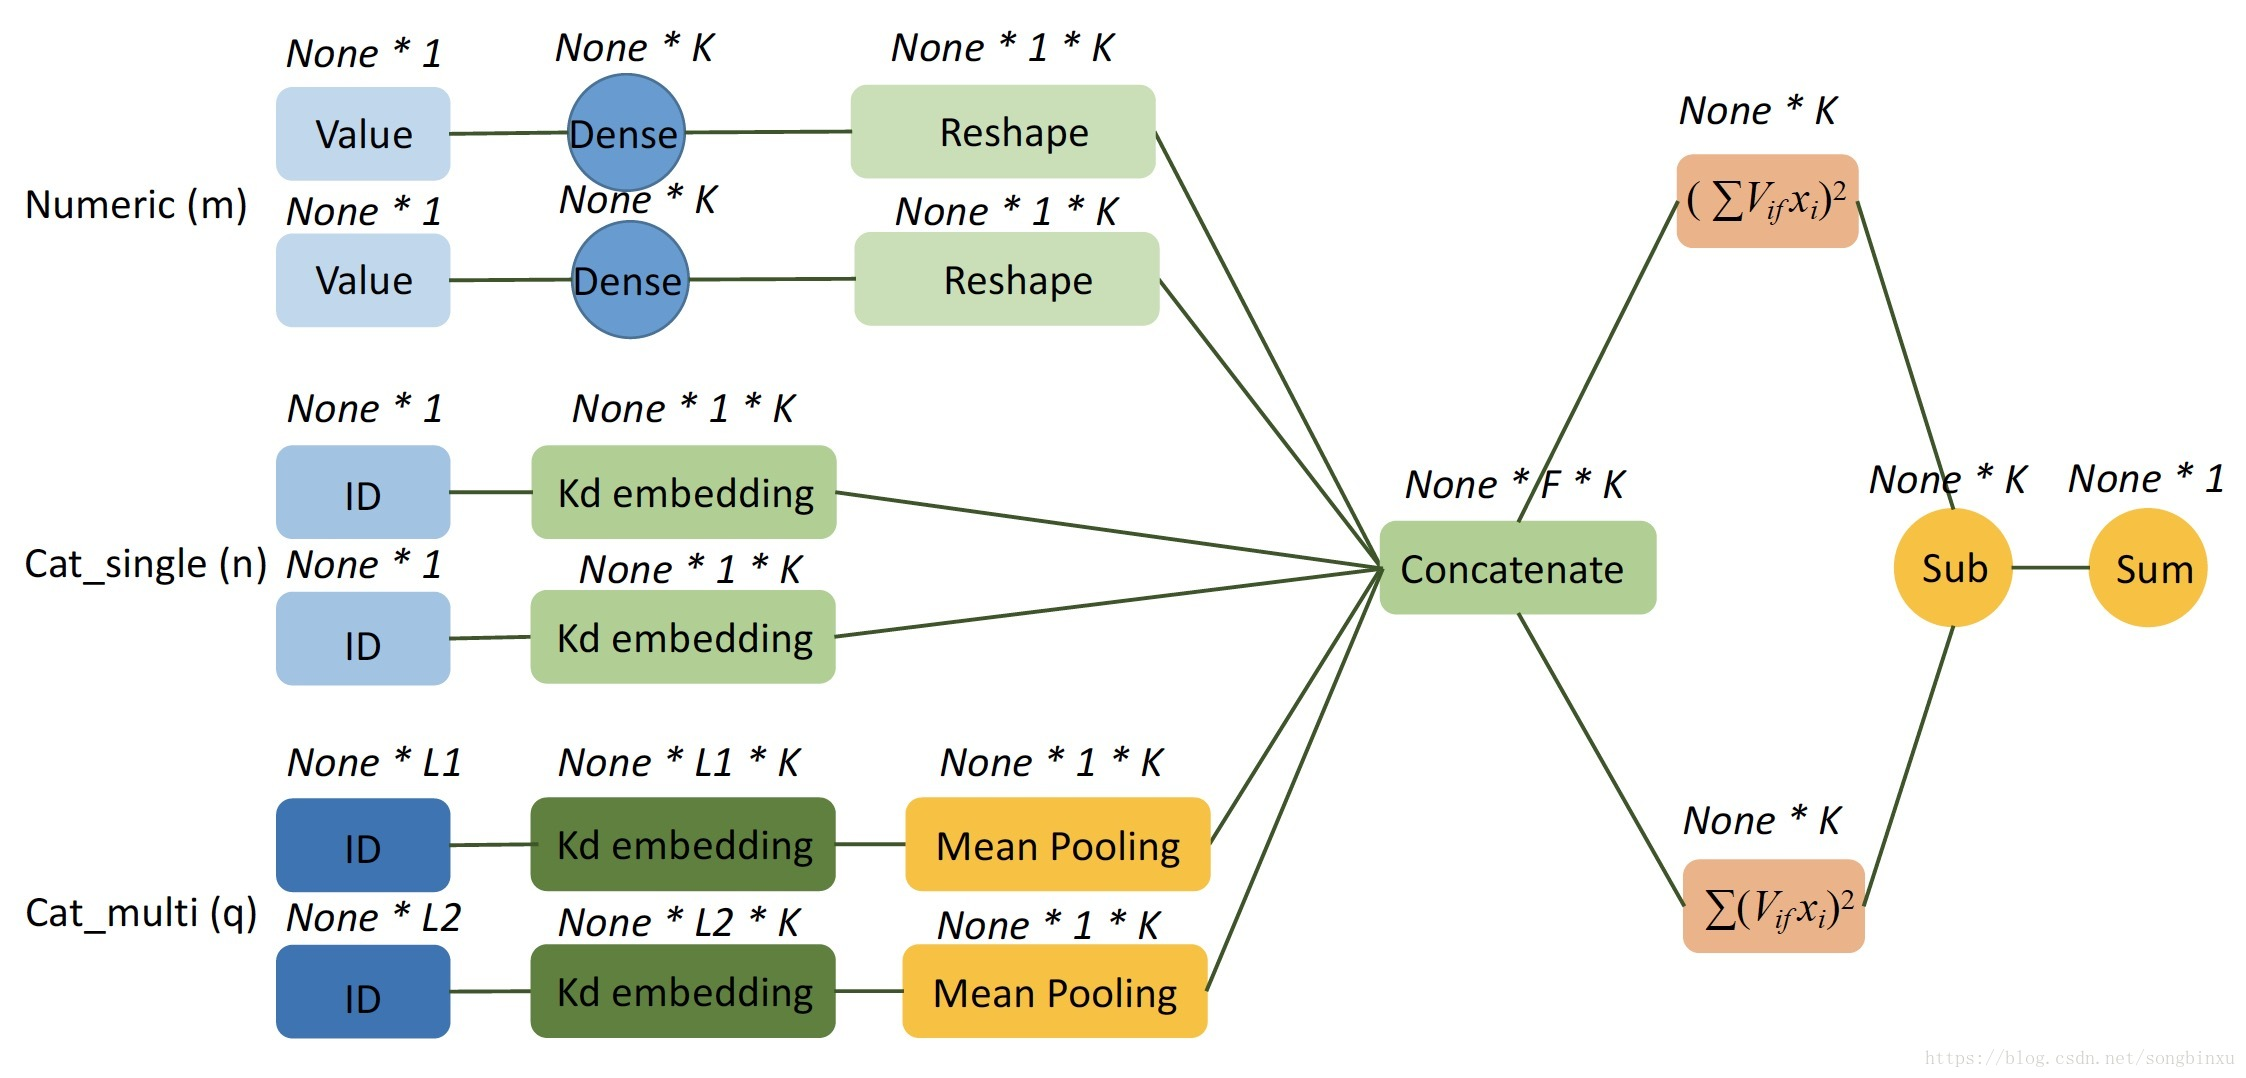

In [24]:
latent = 8
# Second Order Embeddings
emb_score_Kd = RepeatVector(1)(Dense(latent)(in_score)) # None * 1 * K
emb_sales_Kd = RepeatVector(1)(Dense(latent)(in_sales)) # None * 1 * K
emb_gender_Kd = Embedding(3, latent)(in_gender) # None * 1 * K
emb_age_Kd = Embedding(10, latent)(in_age) # None * 1 * K
emb_interest_Kd = Embedding(11, latent, mask_zero=True)(in_interest) # None * 3 * K
emb_interest_Kd = Lambda(lambda x: K.mean(x, axis=1, keepdims=True))(emb_interest_Kd) # None * 1 * K
emb_topic_Kd = Embedding(22, latent, mask_zero=True)(in_topic) # None * 4 * K
emb_topic_Kd = RepeatVector(1)(Lambda(lambda x: K.mean(x, axis=1))(emb_topic_Kd)) # None * 1 * K

emb = Concatenate(axis=1)([emb_score_Kd,
						   emb_sales_Kd,
						   emb_gender_Kd,
						   emb_age_Kd,
						   emb_interest_Kd,
						   emb_topic_Kd]) # None * 6 * K

In [25]:
# compute
summed_features_emb = Lambda(lambda x: K.sum(x, axis=1))(emb) # None * K
summed_features_emb_square = Multiply()([summed_features_emb,summed_features_emb]) # None * K

squared_features_emb = Multiply()([emb, emb]) # None * 6 * K
squared_sum_features_emb = Lambda(lambda x: K.sum(x, axis=1))(squared_features_emb) # Non * K

sub = Subtract()([summed_features_emb_square, squared_sum_features_emb]) # None * K
sub = Lambda(lambda x:x*0.5)(sub) # None * K

y_second_order = Lambda(lambda x: K.sum(x, axis=1, keepdims=True))(sub) # None * 1

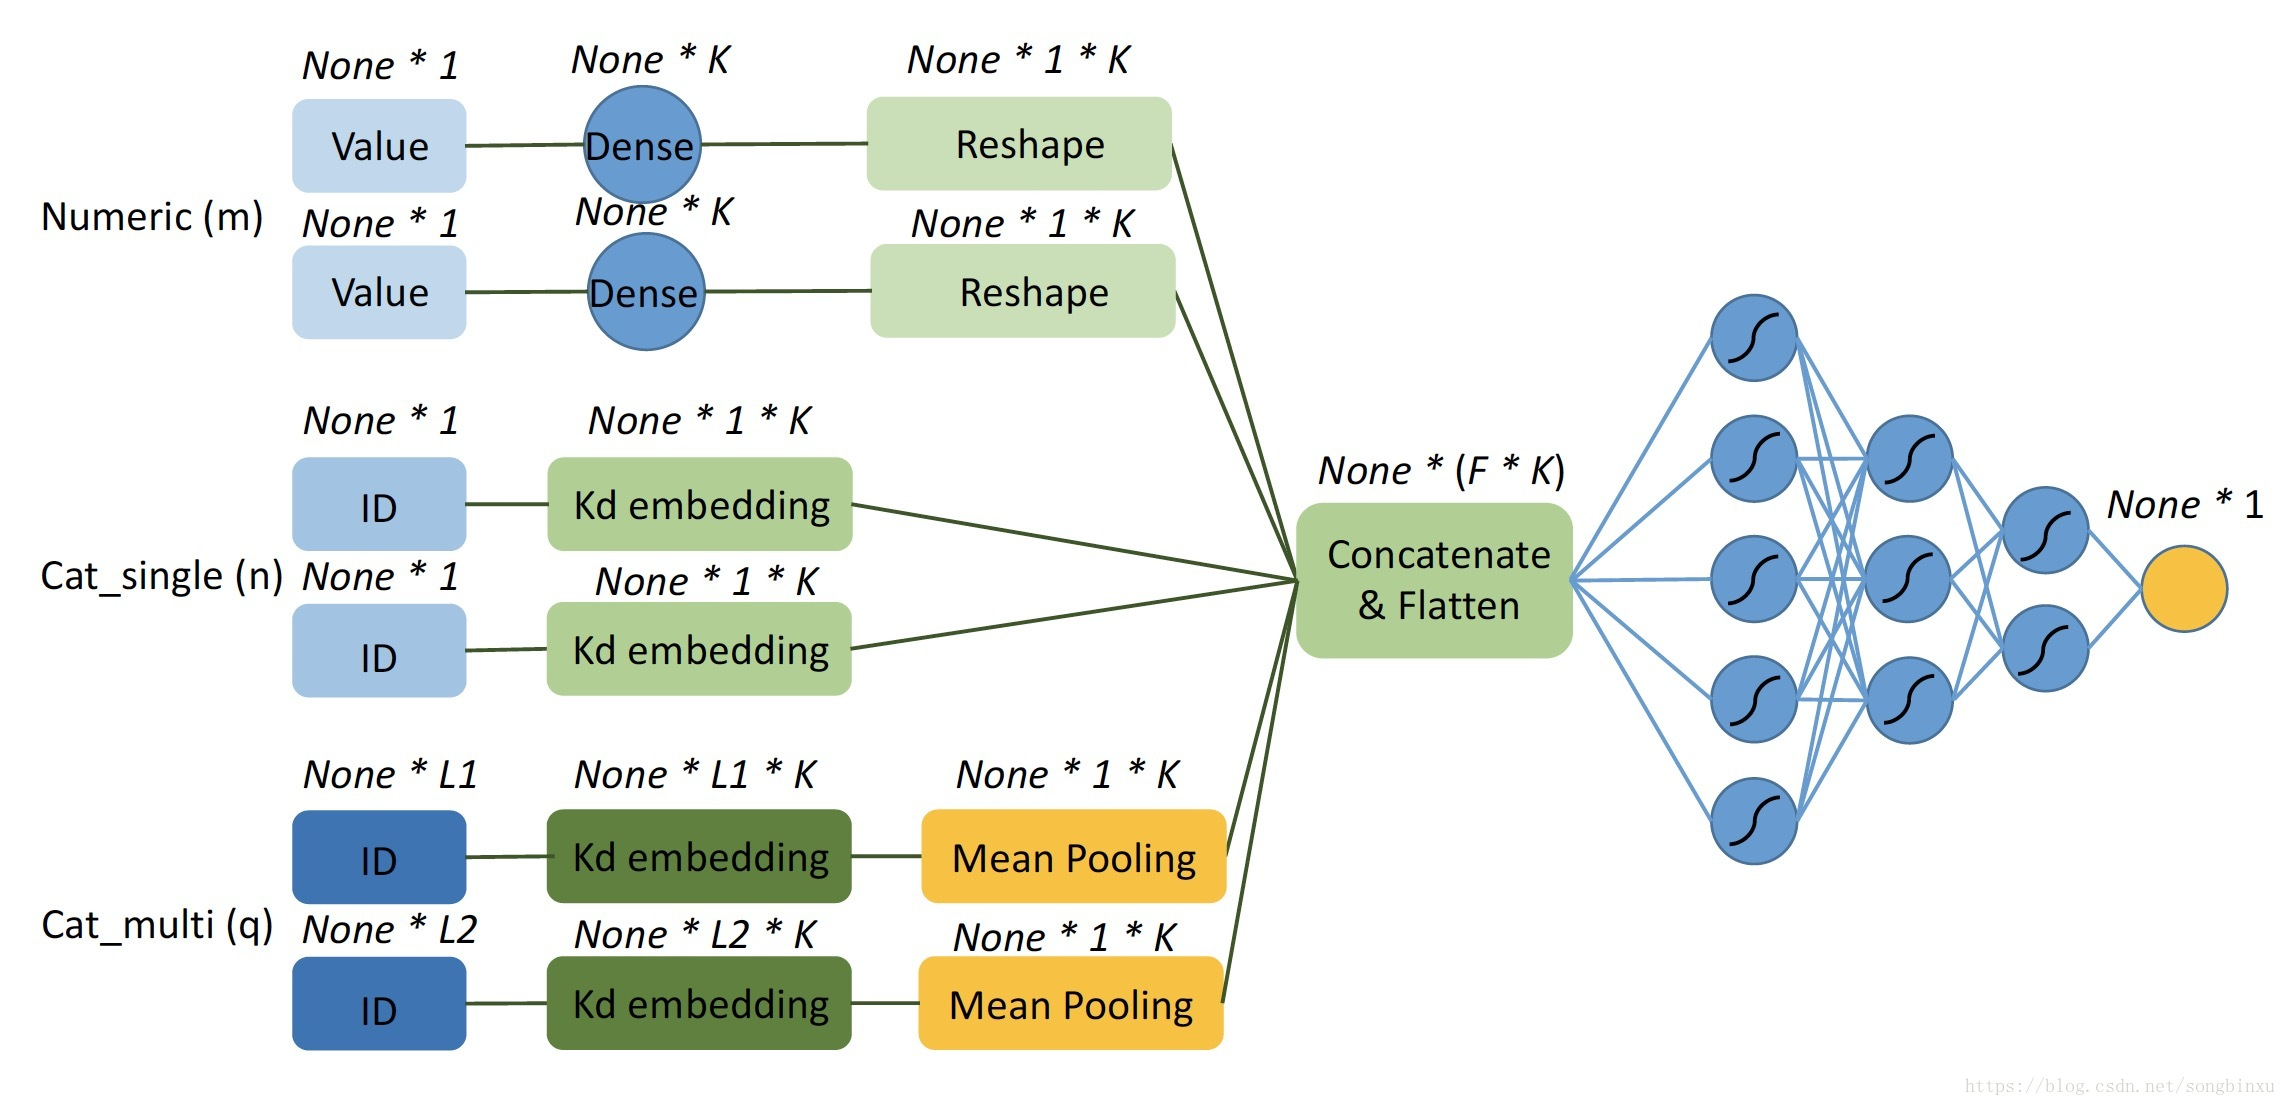

In [26]:
# deep parts
y_deep = Lambda(lambda x: K.reshape(x, (-1, 6 * latent)))(emb) # None*(6*K)
y_deep = Dropout(0.5)(Dense(128, activation='relu')(y_deep))
y_deep = Dropout(0.5)(Dense(64, activation='relu')(y_deep))
y_deep = Dropout(0.5)(Dense(32, activation='relu')(y_deep))
y_deep = Dropout(0.5)(Dense(1, activation='relu')(y_deep))

In [27]:
# deepFM
y = Concatenate(axis=1)([y_first_order, y_second_order, y_deep])
y = Dense(1, activation='sigmoid')(y)

model = Model(inputs=[in_score, in_sales,
                      in_gender, in_age,
                      in_interest, in_topic],
              outputs=[y])
              
plot_model(model, 'model.png', show_shapes=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [ ]:
model.summary()